# Sandbox
### Olivia Cooper
### June 2022

In [11]:
# the basics

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline
import pandas as pd
import astropy
from astropy import units as u
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import ZScaleInterval
from astropy.stats import sigma_clip
from scipy.optimize import curve_fit
plt.style.use('../cooper-paper.mplstyle')

In [2]:
note = Table.read('../wmmc01/detnotes.txt',format='ascii')
mask = Table.read('../wmmc01/wmmc01_SlitList.txt',format='ascii')
note

note,line1,line2,line3,line4
str44,float64,float64,float64,float64
l@10580.2?,10580.2,--,--,--
l@9837.9?,9837.9,--,--,--
star,--,--,--,--
serendip1@10944.5!,10944.5,--,--,--
"bc,l@10936.4",10936.4,--,--,--
"nc,nl",--,--,--,--
"bc,l@10770.3?,l@10217.5?,l@9838.507,l@9847.7",10770.3,10217.5,9838.5,9847.7
l@10675.2?,10675.2,--,--,--
l@9786.3?,9786.3,--,--,--


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os

# for the optimized extraction shape

def gaussian(xaxis, mean, A, sig, offset): 
	'''
	Simple Gaussian function, to be used in the quick optimized extraction
	'''
	return A * np.exp(-np.power(xaxis-mean, 2.) / (2*np.power(sig, 2.))) + offset

def extract1d(obj,path,ycen,aper=7,width=4):
	'''
	Takes a mospy reduced MOS 2D image for a single object and manually extracts the 1D spectrum at 	a given y pixel using both boxcar and optimal extraction methods.
	
	INPUTS ---- obj:		str, name of the reduced 2D MOSFIRE file to be read in
		        path:		str, points to data directory
		        ycen:		int, row to extract spectrum on (pix)
				aper:		int, number of rows to extract the 1D spectrum over
				width:		int, pixel width for boxcar box
				
	RETURNS --- wave:		wavelength array
		        spec:		optimal extracted spectral array
                err:		error for optimal extracted spectral array
				specbox:	boxcar extracted spectral array
                errbox:		error for boxcar extracted spectral array
	'''

	# making sure the aperture is an odd number
	assert aper%2 == 1, "Aperture size needs to be an odd number of pixels. "\
		f"Currently, the aperture size is: \n \t\t  aper = {aper} pixels (default is 7 pixels)."

	# reading in data
	print(f'\nReading in data for {obj}')
	header = fits.getheader(path + obj + '_eps.fits')
	signal = fits.getdata(path + obj + '_eps.fits')
	error = fits.getdata(path + obj + '_sig.fits')
	print(f'Dimensions: \t signal spectrum {signal.shape}\n' +
			f'\t\t error spectrum {error.shape}')
	
	wavelength_start = header['CRVAL1'] # starting wavelength at first pixel
	wavelength_logdisp = header['CD1_1'] # delta wavelength per pixel
	num_wavelength = header['NAXIS1'] # length of data array
	wave = wavelength_start + np.arange(0, wavelength_logdisp*num_wavelength, wavelength_logdisp) # wavelength

	# defining optimized extraction gaussian
	pixscale = header['PSCALE'] # arcsec/pix
	fwhm = 0.8 / pixscale # arcsec / [arcsec/pixel]
	gauss = gaussian(np.arange(aper),mean=3.,A=1.,sig=fwhm/2.35,offset=0.)
	gauss /= sum(gauss) # to make it sum to 1 to use as weights
	gauss_2D = np.zeros((len(gauss),len(wave))) # making 2D array of weights
	for i in range(aper):
		gauss_2D[i] = gauss[i]

	# optimally-extracting 1D spectra
	half = int(aper/2) # to make the cut out of the 2D image
	spec = np.nansum(signal[ycen-half:ycen+half+1].copy()*gauss_2D,axis=0)
	err = np.nansum(error[ycen-half:ycen+half+1].copy()*gauss_2D,axis=0)
    
	# boxcar extract 1D spec
	row1, row2 = ycen-width, ycen+width # define the target aperture range
	specbox = np.sum(signal[row1:row2, :], axis=0)
	errbox = np.sum(error[row1:row2, :], axis=0)
    
	return wave, spec, err, specbox, errbox

In [7]:
### CHANGE THESE TO MATCH YOUR PATH AND OBJECT YOU WANT

obj_name = 'CAND_M44480' ### change me!
dir = '../wmmc03/mospy_products/COMBINED/wmmc03b_COMBINED_' ### change me! this path WILL be different on your computer

In [9]:
# manually extract 1D spec

ypix = 64 ### change me to the ypixel you are extracting the spectrum from
wav, opt, opterr, box, boxerr = extract1d(obj=obj_name,path=dir,ycen=ypix,aper=7,width=4) 


Reading in data for CAND_M44480
Dimensions: 	 signal spectrum (94, 1373)
		 error spectrum (94, 1373)


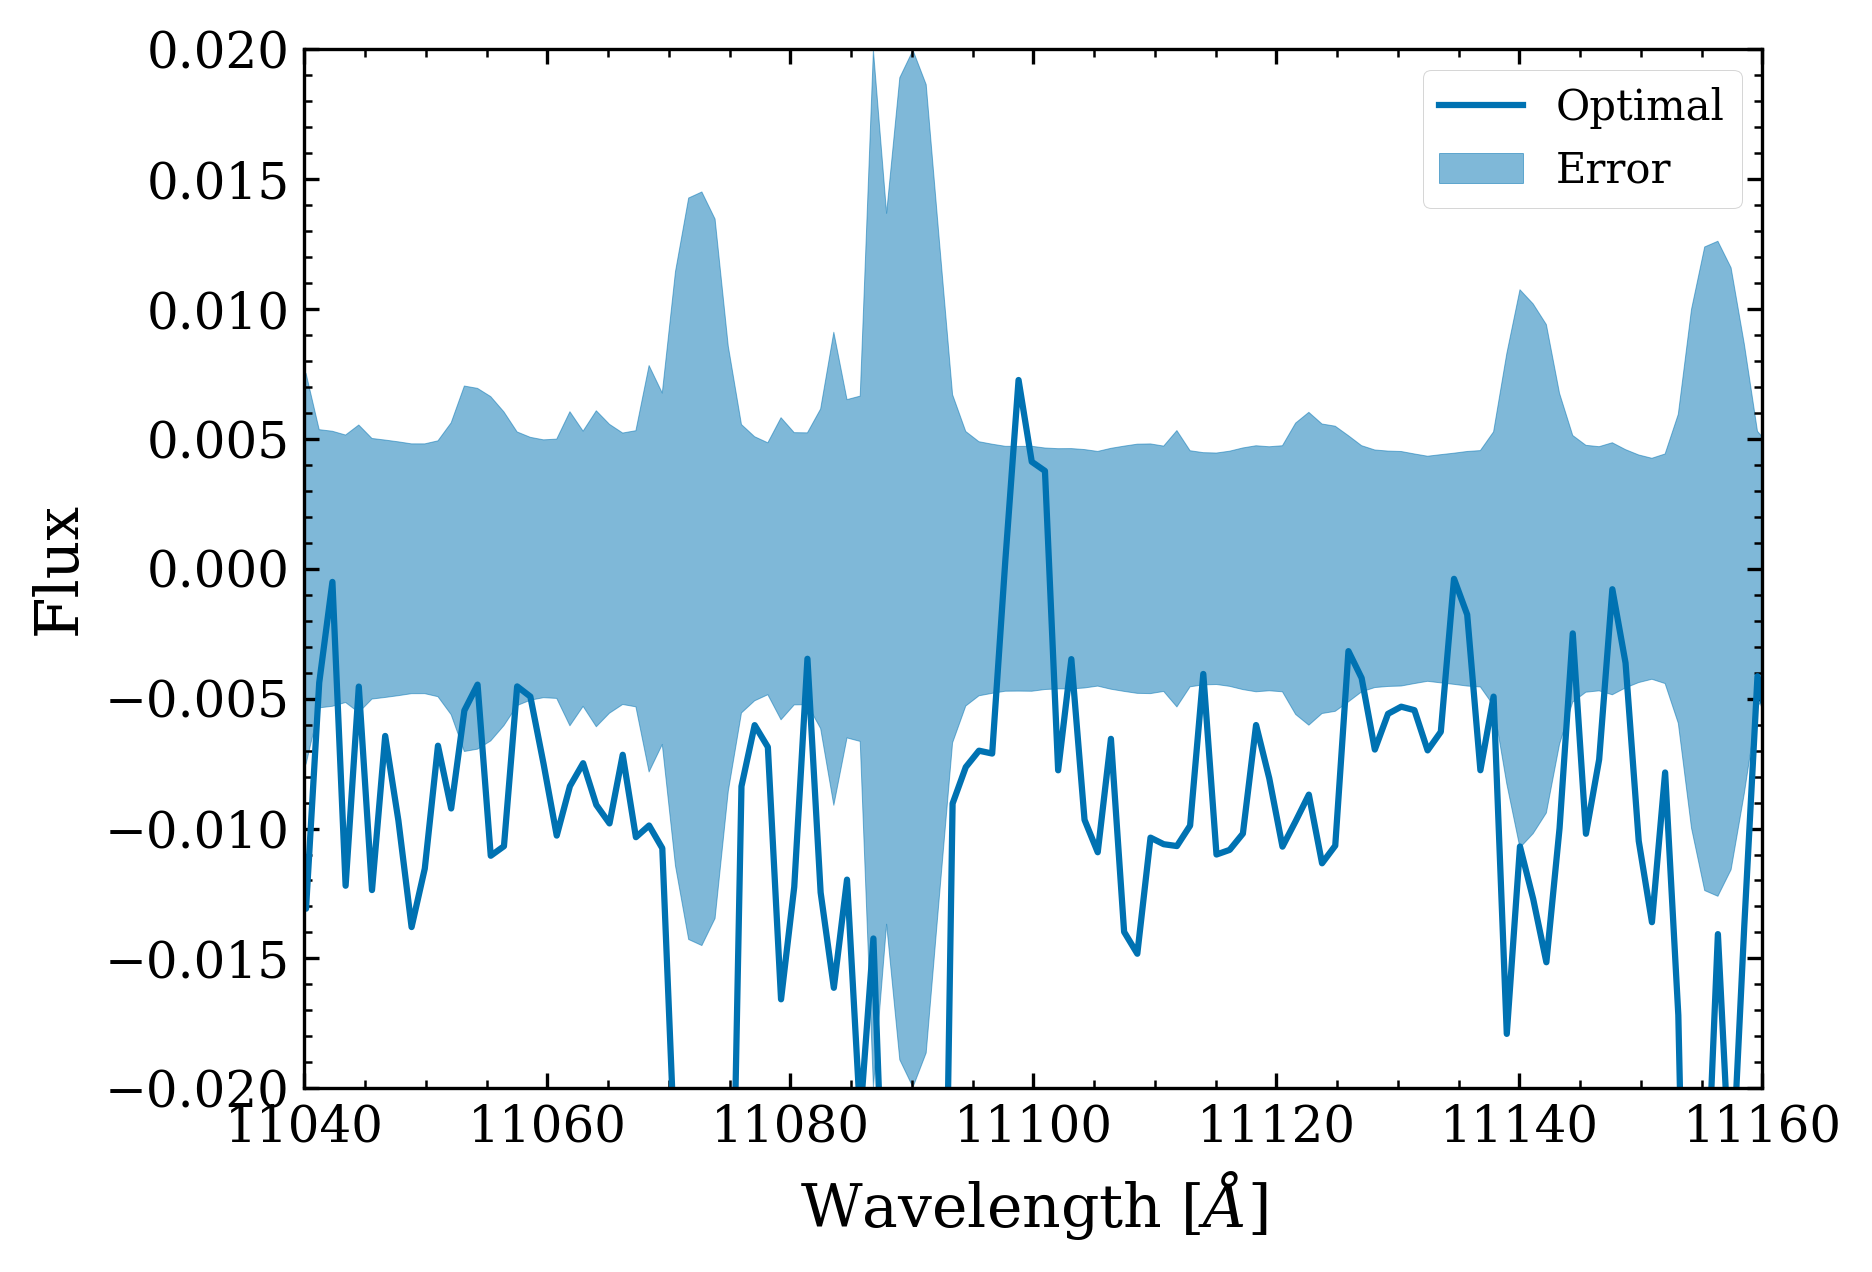

In [14]:
# plot optimal

plt.plot(wav,opt,label='Optimal')
plt.fill_between(wav,opterr,-1*opterr,alpha=0.5,color='C0',label='Error')
plt.xlim(11040,11160) ### change me!
plt.ylim(-0.02,0.02) ### change me!
plt.xlabel(r'Wavelength $[\AA]$')
plt.ylabel(r'Flux')
plt.grid(False)
plt.legend()

In [15]:
path=dir;obj=obj_name
header = fits.getheader(path + obj + '_eps.fits')
signal = fits.getdata(path + obj + '_eps.fits')
error = fits.getdata(path + obj + '_sig.fits')

In [39]:
obj=obj_name;path=dir;ycen=ypix;aper=7;width=4

# making sure the aperture is an odd number
assert aper%2 == 1, "Aperture size needs to be an odd number of pixels. "\
    f"Currently, the aperture size is: \n \t\t  aper = {aper} pixels (default is 7 pixels)."

# reading in data
print(f'\nReading in data for {obj}')
header = fits.getheader(path + obj + '_eps.fits')
signal = fits.getdata(path + obj + '_eps.fits')
error = fits.getdata(path + obj + '_sig.fits')
print(f'Dimensions: \t signal spectrum {signal.shape}\n' +
        f'\t\t error spectrum {error.shape}')

wavelength_start = header['CRVAL1'] # starting wavelength at first pixel
wavelength_logdisp = header['CD1_1'] # delta wavelength per pixel
num_wavelength = header['NAXIS1'] # length of data array
wave = wavelength_start + np.arange(0, wavelength_logdisp*num_wavelength, wavelength_logdisp) # wavelength

# defining optimized extraction gaussian
pixscale = header['PSCALE'] # arcsec/pix
fwhm = 0.8 / pixscale # arcsec / [arcsec/pixel]
gauss = gaussian(np.arange(aper),mean=3.,A=1.,sig=fwhm/2.35,offset=0.)
gauss /= sum(gauss) # to make it sum to 1 to use as weights
gauss_2D = np.zeros((len(gauss),len(wave))) # making 2D array of weights
for i in range(aper):
    gauss_2D[i] = gauss[i]

# optimally-extracting 1D spectra
half = int(aper/2) # to make the cut out of the 2D image
spec = np.nansum(signal[ycen-half:ycen+half+1].copy()*gauss_2D,axis=0)
err = np.nansum(signal[35-half:35+half+1].copy()*gauss_2D,axis=0)

# boxcar extract 1D spec
row1, row2 = ycen-width, ycen+width # define the target aperture range
specbox = np.sum(signal[row1:row2, :], axis=0)
errbox = np.sum(error[row1:row2, :], axis=0)


Reading in data for CAND_M44480
Dimensions: 	 signal spectrum (94, 1373)
		 error spectrum (94, 1373)


In [40]:
from astropy.stats import SigmaClip
from photutils.background import StdBackgroundRMS
sigma_clip = SigmaClip(sigma=3.0)
bkgrms = StdBackgroundRMS(sigma_clip)

In [51]:
bkgrms_value = bkgrms.calc_background_rms(signal,axis=0)
bkgrms_value

array([0.00524341, 0.00590753, 0.00641911, ..., 0.        , 0.        ,
       0.        ])

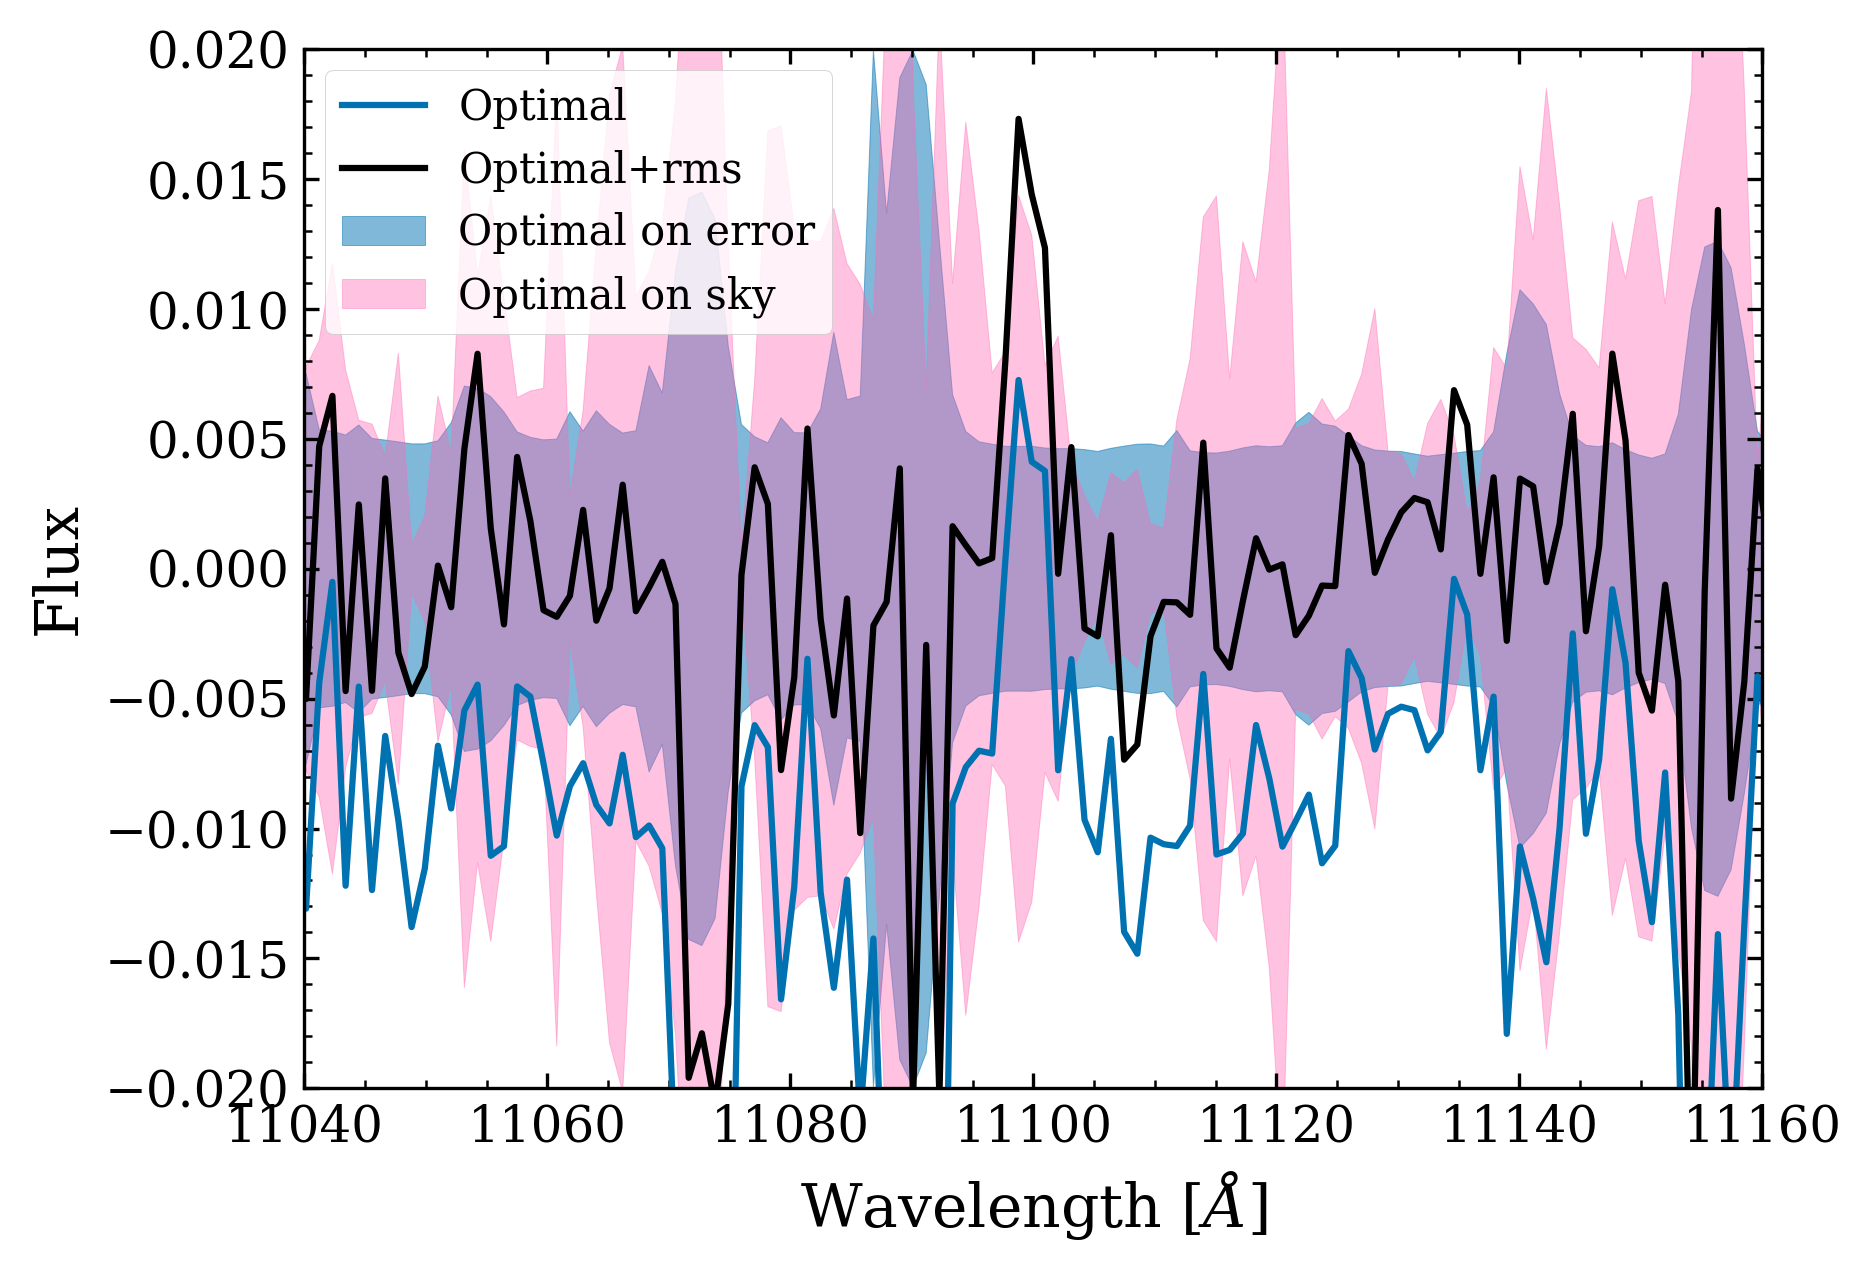

In [61]:
# plot optimal

plt.plot(wav,opt,label='Optimal')
plt.plot(wav,opt+bkgrms_value,'k',label='Optimal+rms')

plt.fill_between(wav,opterr,-1*opterr,alpha=0.5,color='C0',label='Optimal on error')
plt.fill_between(wav,err,-1*err,alpha=0.4,color='hotpink',label='Optimal on sky')

plt.xlim(11040,11160) ### change me!
plt.ylim(-0.02,0.02) ### change me!
plt.xlabel(r'Wavelength $[\AA]$')
plt.ylabel(r'Flux')
plt.grid(False)
plt.legend()
plt.savefig('cand_m44480_rms_test.png')

In [46]:
np.median(opt),np.median(opt+bkgrms_value)

(-0.008327997009806798, 0.0009683708664248725)